# DOE eksempel 2: Produktuniformitet

*Eksempelet og dataene er hentet fra National Institute of Standards and Technology (USA) https://www.itl.nist.gov/div898/handbook/pri/section3/pri3331.htm*

En ingeniør skal undersøke hvilken av tre ulike instillinger på et produksjonsverktøy som har størst effekt på produktuniformitet. Responsvariabelen ("produktuniformitet") er et mål på avvik fra en bestemt standard. Ingeniøren vurdererte tre faktorer (maskin-instillinger) som vi kaller $A$, $B$ og $C$, og for hver av disse ble det bestemt et lavt og et høyt nivå. Dette er kodet som $x_1 = -1$ og $x_1 = +1$ for faktor $A$, $x_2 = -1$ og $x_2 = +1$ for faktor $B$, og $x_3 = -1$ og $x_3 = +1$ for faktor $C$.

Det ble gjennomført et $2^3$ forsøk med gjentak, totalt 16 observasjoner. Forsøkene med faktorkombinasjoner og resultater er lagret i excel-fila produktuniformitet.xlsx.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sms
import statsmodels.formula.api as smf
from scipy import stats

In [2]:
run DOEfunksjoner.ipynb 

Vi starter med å lese inn dataene fra excel-arket.

In [4]:
data = pd.read_excel('produktuniformitet.xlsx')
data

,x1,x2,x3,y1,y2
0,-1,-1,-1,-3,-1
1,1,-1,-1,0,-1
2,-1,1,-1,-1,0
3,1,1,-1,2,3
4,-1,-1,1,-1,0
5,1,-1,1,2,1
6,-1,1,1,1,1
7,1,1,1,6,5


Merk at denne måten å registrere data på er hensiktsmessig for forsøk med gjentak, men passer ikke for å gjøre regresjonsanalyse. Vi lager oss derfor en pandas data frame der de to gjentakene kommer "under hverandre". 

In [5]:
# Vi må få dataene over på et format som passer til regresjonsanalysen
df1 = data.iloc[:8, :4]
df1.rename(columns = {'y1':'y'}, inplace = True)
df2 = data.iloc[:8, [0, 1, 2, 4]]
df2.rename(columns = {'y2':'y'}, inplace = True)
df = pd.concat([df1, df2], axis=0)
#df skriv ut for å se hvordan dataene nå er sortert

## Plott av hovedeffekter og samspillseffekter

Vi begynner med å visualisere hovedeffekter for tre faktorene, og deretter samspill. Merk at et forsøk kan ha mange høyere ordens effekter; i dette tilfellet tre forskjellige tofaktorsamspill ($AB$, $AC$ og $BC$) og et trefaktorsamspill ($ABC$). Vi skal undersøke tofaktorsamspillene her, men vi går ut ifra at høyere ordens sampspill er neglisjerbare. 

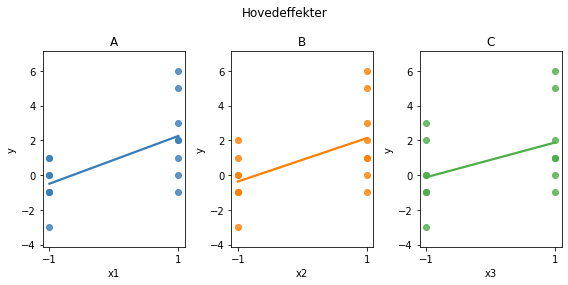

In [6]:
hovedeffektsplott(data = df, k = 3, observasjoner = True)

Fra hovedeffektsplottene ser vi svært like effekter av de tre faktorene A, B og C.

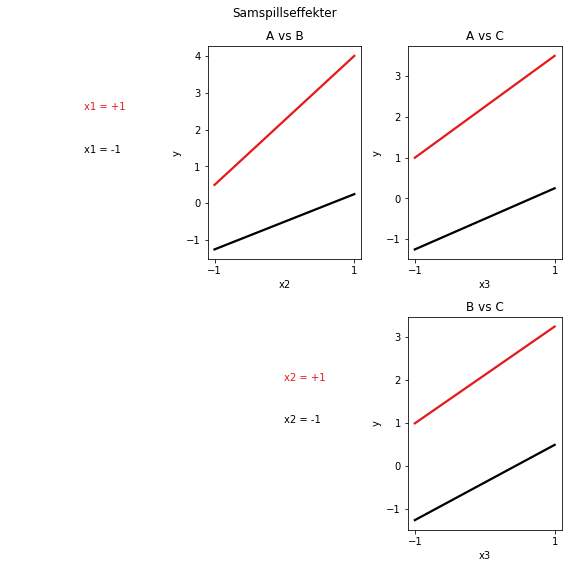

In [8]:
samspillsplott(data = df, k = 3)

I figuren over ser vi tre sampspillsplott. Øverst til venstre ser vi effekten av faktor $B$ når $A$ er på lavt ($x_1 = -1$) og høyt $(x_1 = +1)$ nivå. Øverst til høyre ser vi effekten av faktor $B$ når $A$ er på lavt og høyt nivå. Nederst til høyre ser vi effekten av $C$ når $B$ er på lavt ($x_2 = -1$) og høyt ($x_2 = +1$) nivå. I samspillsplottet til $AB$ ser vi at de to linjene har ganske ulikt stigningstall. Dette kan tyde på at det finnes indikasjoner i dataene på et samspill mellom faktorene $A$ og $B$. 

## Multippel lineær regresjon
Vi bruker Python til å tilpasse en multippel lineær regresjonsmodell med alle tofaktorsamspill og trefaktor samspill. 

In [9]:
modell = smf.ols('y~x1+x2+x3 + x1*x2 + x2*x3 + x1*x3 + x1*x2*x3', data=df).fit()
print(modell.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     17.54
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           0.000290
Time:                        11:20:46   Log-Likelihood:                -13.398
No. Observations:                  16   AIC:                             42.80
Df Residuals:                       8   BIC:                             48.98
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8750      0.198      4.427      0.0

/Users/theabj/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Vi ser at alle hovedeffektene til faktoren $A$, $B$ og $C$ er signifikante ($p$-verdiene er lavere enn $0.05$). Hovedeffektene er 

$\hat{A} = 2 \cdot 1.375 = 2.75$, 

$\hat{B} = 2 \cdot 1.250 = 2.50$,

$\hat{C} = 2 \cdot 1.000 = 2.00$.

Vi ser også at samspillet mellom faktorene $A$ og $B$ er signifikant. Effektene er visualisert i Paretoplottet under.

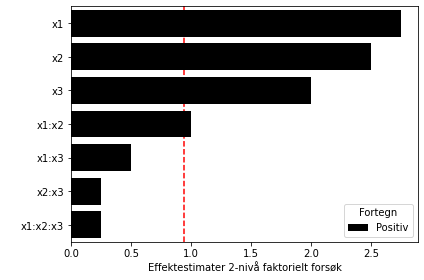

In [10]:
DOEparetoplott(modell)

In [12]:
# til slutt kan det være nyttig å skrive ut estimatet på variansen og standardavviket til Y:
varY = modell.mse_resid
sdY = np.sqrt(varY)
print(round(sdY,3))

0.791


## Konklusjon

Vi observerer at både hovedeffekter og samspillseffekter har positivt fortegn. Det vil si at høye nivåer av faktorene alltid er forbundet med økt respons. I dette tilfellet er økt respons det samme som høyere produktuniformitet, som er et ønskelig resultat. Produksjonsverktøyet bør derfor stilles inn på høyt nivå for alle faktorer. Dersom ikke alle faktorer kan stilles på høyt nivå bør faktorene $A$ og $B$ prioriteres da disse har størst hovedeffekt i tillegg til et positivt samspill.

## Diskusjon

I dette eksempelet har vi sett en analyse av resulatetene fra et $2^3$ faktorielt forsøk med gjentak. Det er rekke svakheter i problembeskrivelsen som er hentet fra NIST (national institute of standards and technology). Vi vet verken hvordan responsvariabelen i praksis ble regnet ut, og vi vet veldig lite om de tre faktorene $A$, $B$ og $C$. I et skikkelig forsøk må dette beskrives slik at forsøket både kan forstås og reproduseres. I dette forsøket ser vi også at responsverdien er registrert i heltallsverdier, noe som ikke nødvendigvis passer godt med normalantagelsen. 

For å sjekke normalantagelsen kan vi plotte et QQ-plott på samme måte som i Fellesmodulen Uke 9. Vi ser QQ-plottet i figuren under. Vi ser en slags trappe-effekt i QQ-plottet fordi observasjonene av $Y$ har heltallsverdier, men ellers ser vi ingen iøyenfallende avvik fra den røde linja. Normaltilnærmingen ser ut til å være OK for dataene. 

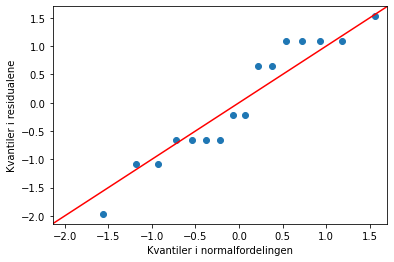

In [60]:
sms.qqplot(modell.resid,line='45',fit=True)
plt.ylabel("Kvantiler i residualene")
plt.xlabel("Kvantiler i normalfordelingen")
plt.show()